In [3]:
#!/usr/bin/env python3
# %%
"""Jupyter‑friendly analysis of Bench360 CSV results *with on‑the‑fly metric fix‑up*.

*Corrects the batch‑latency duplication bug before aggregating stats.*

Outputs
-------
* Latency table (choose GL / ATL / TTFT via `primary_metric`)
* Best backend for single‑stream (batch = 1)
* Speed‑up table from batch 1 → largest batch
* Throughput (TPS) and Energy‑per‑Token tables
"""
# %%
import glob
import os
import re
import pandas as pd
from typing import Optional
from IPython.display import display

# Path that holds all CSV result files
results_dir = "/home/ubuntu/fast_llm_inference/results"  # ← edit if needed

# ────────────────────────────────────────────────────────────────────────────────
# Fix‑metrics helper (retro‑fits per‑request latency & energy)
# ────────────────────────────────────────────────────────────────────────────────
_tok_re  = re.compile(r"\S+")
_sent_re = re.compile(r"[.!?…]+")

def _tok_cnt(text: str) -> int:
    return len(_tok_re.findall(str(text)))

def _sent_cnt(text: str) -> int:
    return max(len(_sent_re.findall(str(text))), 1)

def fix_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """Distribute batch wall‑clock time & energy across individual rows.

    Assumes the **original benchmark duplicated batch GL / energy** across every
    sample.  We divide those by the true batch size and recompute ATL, TPS, SPS,
    and energy intensities.
    """
    df = df.copy()

    # ensure token / sentence counts
    if "num_tokens" not in df:
        df["num_tokens"] = df["generated_answer"].map(_tok_cnt)
    if "num_sentences" not in df:
        df["num_sentences"] = df["generated_answer"].map(_sent_cnt)

    # infer batch size from the column (added later) or count
    batch_size = int(df["batch_size"].iloc[0] if "batch_size" in df else len(df))
    df["batch_id"] = (df.index // batch_size).astype(int)

    # batch‑level aggregates
    df["batch_time_s"]    = df.groupby("batch_id")["GL"].transform("max")
    df["batch_tokens"]    = df.groupby("batch_id")["num_tokens"].transform("sum")
    df["batch_sentences"] = df.groupby("batch_id")["num_sentences"].transform("sum")

    # corrected latency & throughput
    df["ATL"] = df["batch_time_s"] / df["batch_tokens"]
    df["GL"]  = df["ATL"] * df["num_tokens"]
    df["TPS"] = df["num_tokens"] / df["GL"]
    df["SPS"] = df["num_sentences"] / df["GL"]

    # energy (optional)
    if "Total Energy (Wh)" in df:
        batch_energy_wh = df.groupby("batch_id")["Total Energy (Wh)"].transform("max")
        df["Energy per Token (J/token)"]      = (batch_energy_wh * 3600) / df["batch_tokens"]
        df["Energy per Sentence (J/sentence)"] = (batch_energy_wh * 3600) / df["batch_sentences"]

    # clean up helpers
    df.drop(columns=[
        "batch_id", "batch_time_s", "batch_tokens", "batch_sentences",
        "num_tokens", "num_sentences"
    ], inplace=True, errors="ignore")

    return df

# ────────────────────────────────────────────────────────────────────────────────
# Helper — parse backend / model / task / batch from filename
# ────────────────────────────────────────────────────────────────────────────────

def _parse_filename(path: str):
    fname = os.path.basename(path)
    m = re.match(r"(?P<backend>[^_]+)_(?P<model>.+?)_(?P<task>[^_]+)_(?P<bs>\d+)batch\.csv", fname)
    if not m:
        return None
    return m.group("backend"), m.group("model"), m.group("task"), int(m.group("bs"))

# %%
# ── Load every CSV → DataFrame with metrics fixed on the fly ───────────────────
frames = []
for csv_path in glob.glob(os.path.join(results_dir, "*.csv")):
    parsed = _parse_filename(csv_path)
    if not parsed:
        continue  # unrelated file
    backend, model, task, bs = parsed

    df_part = pd.read_csv(csv_path)
    df_part["backend"]    = backend
    df_part["model"]      = model
    df_part["task"]       = task
    df_part["batch_size"] = bs

    df_part = fix_metrics(df_part)  # ← apply correction here
    frames.append(df_part)

if not frames:
    raise RuntimeError(f"No CSV files found in {results_dir} – check the path.")

results = pd.concat(frames, ignore_index=True)
print(f"Loaded {len(results):,} corrected rows from {len(frames)} CSV files")

# %%
# ── Configure which latency metric drives the ranking ───────────────────────────
primary_metric = "GL"  # choose "GL", "ATL", or "TTFT" (post‑fix, if TTFT logged)

# Latency per backend × batch size
summary = (
    results.groupby(["backend", "batch_size"], as_index=False)[primary_metric]
           .mean()
)
latency_table = summary.pivot(index="backend", columns="batch_size", values=primary_metric)

# %% [markdown]
# ### Best backend for single‑stream (batch = 1)

# %%
best_row = summary[summary["batch_size"] == 1].loc[lambda d: d[primary_metric].idxmin()]
print(f"🏆 Best latency in single‑stream: {best_row['backend']} ({best_row[primary_metric]:.2f} {primary_metric})")

# %%
# ── Scaling behaviour: speed‑up from batch 1 → largest batch ────────────────────
largest_bs = summary["batch_size"].max()
speedup_table = (latency_table[1] / latency_table[largest_bs]).rename(f"latency ratio (1→{largest_bs})")

# %%
# Throughput (tokens/s) and Energy (J/token) tables
throughput = results.groupby(["backend", "batch_size"], as_index=False)["TPS"].mean().pivot(index="backend", columns="batch_size", values="TPS")
energy = results.groupby(["backend", "batch_size"], as_index=False)["Energy per Token (J/token)"].mean().pivot(index="backend", columns="batch_size", values="Energy per Token (J/token)") if "Energy per Token (J/token)" in results else None

# %%
# ── Display nicely in Jupyter ───────────────────────────────────────────────────
print("\nLatency table (ms):")
display(latency_table.round(2))
print(f"\nLatency growth 1 → {largest_bs}:")
display(speedup_table.sort_values().round(2))
print("\nThroughput (tokens/s):")
display(throughput.round(2))
if energy is not None:
    print("\nEnergy per Token (J):")
    display(energy.round(4))

print("\nAnalysis complete – metrics fixed in‑memory. 🎉")


Loaded 11,100 corrected rows from 111 CSV files
🏆 Best latency in single‑stream: vllm (3.52 GL)

Latency table (ms):


batch_size,1,8,16,32,64
backend,,,,,
huggingface,4.30,4.48,4.51,4.53,4.51
llama.cpp,3.87,3.80,3.79,3.80,3.81
vllm,3.52,0.97,0.64,0.43,0.32



Latency growth 1 → 64:


backend
huggingface     0.95
llama.cpp       1.02
vllm           10.98
Name: latency ratio (1→64), dtype: float64


Throughput (tokens/s):


batch_size,1,8,16,32,64
backend,,,,,
huggingface,16.54,14.31,14.07,14.06,14.03
llama.cpp,29.29,28.37,28.30,29.01,28.88
vllm,32.89,181.63,293.04,330.27,556.75



Energy per Token (J):


batch_size,1,8,16,32,64
backend,,,,,
huggingface,5.0947,5.5479,5.5777,5.6173,5.6039
llama.cpp,4.4014,4.4083,4.4243,4.4265,4.4313
vllm,3.6250,0.8474,0.5510,0.3895,0.3099



Analysis complete – metrics fixed in‑memory. 🎉


try to combine single, batch and server to one. 

In [25]:
#!/usr/bin/env python3
"""Unified analysis for *single, batch, server* CSVs in `experiment_3/`.

Matches filenames like
    backend_model_task_16batch.csv
    backend_model_task_4QPS_120s_server.csv
Corrects duplicated batch metrics and prints latency / throughput tables.
"""
# %% ── imports & helpers ──────────────────────────────────────────────────────
import os, re, glob, pandas as pd

TOK  = re.compile(r"\S+")
SENT = re.compile(r"[.!?…]+")

def _tok_cnt(t):   return len(TOK.findall(str(t)))

def _sent_cnt(t):  return max(len(SENT.findall(str(t))), 1)

# ── filename parser -----------------------------------------------------------
FILE_RE = re.compile(
    r"""
    (?P<backend>[^_]+)_
    (?P<model>[^_]+)_
    (?P<task>[^_]+)_
    (?:
        (?P<batch>\d+)batch |                       # e.g. 32batch
        (?P<qps>\d+)QPS_(?P<secs>\d+)s_server      # e.g. 4QPS_120s_server
    )\.csv$""", re.X)

def parse_name(path):
    m = FILE_RE.search(os.path.basename(path))
    if not m: return None
    d = m.groupdict()
    if d["batch"]:
        return d["backend"], d["model"], d["task"], "batch - size", int(d["batch"])
    return d["backend"], d["model"], d["task"], "server - QPS", int(d["qps"])

# ── metric fixes --------------------------------------------------------------

def _row_fix(df):
    df = df.copy()
    df["tok"]  = df["generated_answer"].map(_tok_cnt)
    df["sent"] = df["generated_answer"].map(_sent_cnt)
    df["GL"]  = df["GL"] / df["batch_size"]
    df["ATL"] = df["GL"] / df["tok"]
    df["TPS"] = df["tok"] / df["GL"]
    df["SPS"] = df["sent"] / df["GL"]
    return df

def fix_batch(df):
    df = _row_fix(df)
    df["total_latency"] = df["GL"]
    return df.drop(columns=["tok","sent"], errors="ignore")

def fix_server(df):
    """Correct metrics for *server* runs where no explicit `batch_size` exists.
    We infer the launch‑batch size as the number of rows that share the same
    `start_ts`, which corresponds to one CUDA decoding call.
    """
    df = df.copy()

    # per‑request counts
    df["tok"]  = df["generated_answer"].map(_tok_cnt)
    df["sent"] = df["generated_answer"].map(_sent_cnt)

    # infer group (launch) size via shared start timestamp
    df["launch_size"] = df.groupby("start_ts")['generated_answer'].transform('size')

    # adjust latency & throughput
    df["GL"]  = df["GL"] / df["launch_size"]
    df["ATL"] = df["GL"] / df["tok"]
    df["TPS"] = df["tok"] / df["GL"]
    df["SPS"] = df["sent"] / df["GL"]
    df["total_latency"] = df["wait_time"] + df["GL"]

    return df.drop(columns=["tok","sent","launch_size"], errors="ignore")

# %% ── load & process all CSVs ───────────────────────────────────────────────-
rows = []
results_dir = "/home/ubuntu/fast_llm_inference/results/experiment_3"
for csv in glob.glob(os.path.join(results_dir, "*.csv")):
    meta = parse_name(csv)
    if not meta:
        continue
    backend, model, task, scenario, load = meta
    df = pd.read_csv(csv)
    # Inject missing batch_size for batch runs parsed from filename
    if "batch_size" not in df.columns:
        df["batch_size"] = load
    df["backend"], df["model"], df["task"] = backend, model, task
    df["scenario"], df["load"] = scenario, load
    df = fix_server(df) if scenario == "server" else fix_batch(df)
    rows.append(df)

data = pd.concat(rows, ignore_index=True)

# %% ── aggregate latency & throughput ─────────────────────────────────────────
summary = (data.groupby(["backend","scenario","load"], as_index=False)
               .agg(lat_ms = ("total_latency","mean"),
                    tps    = ("TPS","mean")))

lat_tab = summary.pivot_table(index="backend", columns=["scenario","load"], values="lat_ms")
tps_tab = summary.pivot_table(index="backend", columns=["scenario","load"], values="tps")

print("Generation latency (s) per request:")
display(lat_tab.round(2))

print("\nThroughput (tokens/s):")
display(tps_tab.round(1))

Generation latency (s) per request:


scenario    batch - size                         server - QPS              \
load                  1     8     16    32    64           1     2     4    
backend                                                                     
huggingface         4.30  4.19  4.17  4.15  3.65         1.86  1.92  1.92   
llama.cpp           3.87  3.73  3.69  3.68  3.22         2.18  1.73  1.73   
vllm                3.52  0.95  0.60  0.39  0.26         0.72  0.44  0.24   

scenario           
load           8   
backend            
huggingface  1.78  
llama.cpp    2.01  
vllm         0.12


Throughput (tokens/s):


scenario    batch - size                             server - QPS              \
load                  1      8      16     32     64           1     2     4    
backend                                                                         
huggingface         16.5   16.7   17.8   20.6   19.7         10.2  10.1  10.5   
llama.cpp           29.3   29.6   32.0   37.2   37.0         14.6  18.0  17.0   
vllm                32.9  185.7  305.4  356.1  667.1         30.6  48.8  85.2   

scenario            
load            8   
backend             
huggingface   10.7  
llama.cpp     16.4  
vllm         150.4

In [28]:
#!/usr/bin/env python3
"""Unified analysis for *single, batch, server* CSVs split by model‑size class.

Model‑size classes (editable):
    tiny   < 1 B parameters
    small  ≥ 1 B and < 4 B
    medium ≥ 4 B and ≤ 9 B

Filenames accepted:
    backend_model_task_16batch.csv
    backend_model_task_4QPS_120s_server.csv
"""
# %% ── imports ────────────────────────────────────────────────────────────────
import os, re, glob, pandas as pd

TOK = re.compile(r"\S+")
SENT= re.compile(r"[.!?…]+")

# ── model‑size classifier ------------------------------------------------------
SIZE_RE = re.compile(r"([\d.]+)\s*[bB]")

def size_class(model_name: str) -> str:
    """Return 'tiny' | 'small' | 'medium' class based on #params in model name."""
    m = SIZE_RE.search(model_name)
    if not m:
        return "unknown"
    n_b = float(m.group(1))   # e.g. "3.2" → 3.2 B
    if n_b <= 1.5:      return "tiny"
    if n_b < 4:      return "small"
    return "medium"   # up to 9 B in our experiments

# ── lightweight counters ------------------------------------------------------

def _tok_cnt(t):   return len(TOK.findall(str(t)))

def _sent_cnt(t):  return max(len(SENT.findall(str(t))), 1)

# ── filename parser -----------------------------------------------------------
FILE_RE = re.compile(r"""
    (?P<backend>[^_]+)_
    (?P<model>[^_]+)_
    (?P<task>[^_]+)_
    (?:
        (?P<batch>\d+)batch |
        (?P<qps>\d+)QPS_(?P<secs>\d+)s_server
    )\.csv$""", re.X)

def parse_name(path):
    m = FILE_RE.search(os.path.basename(path))
    if not m:
        return None
    d = m.groupdict()
    if d["batch"]:
        return d["backend"], d["model"], d["task"], "batch-size", int(d["batch"])
    return d["backend"], d["model"], d["task"], "server‑QPS", int(d["qps"])

# ── metric fixes --------------------------------------------------------------

def _row_fix(df):
    df = df.copy()
    df["tok"]  = df["generated_answer"].map(_tok_cnt)
    df["sent"] = df["generated_answer"].map(_sent_cnt)
    df["GL"]   = df["GL"] / df["batch_size"]
    df["ATL"]  = df["GL"] / df["tok"]
    df["TPS"]  = df["tok"] / df["GL"]
    df["SPS"]  = df["sent"] / df["GL"]
    return df

def fix_batch(df):
    df = _row_fix(df)
    df["total_latency"] = df["GL"]
    return df.drop(columns=["tok","sent"], errors="ignore")

def fix_server(df):
    df = df.copy()
    df["tok"]  = df["generated_answer"].map(_tok_cnt)
    df["sent"] = df["generated_answer"].map(_sent_cnt)
    df["launch"] = df.groupby("start_ts")["tok"].transform("size")
    df["GL"]   = df["GL"] / df["launch"]
    df["ATL"]  = df["GL"] / df["tok"]
    df["TPS"]  = df["tok"] / df["GL"]
    df["SPS"]  = df["sent"] / df["GL"]
    df["total_latency"] = df["wait_time"] + df["GL"]
    return df.drop(columns=["tok","sent","launch"], errors="ignore")

# %% ── load all CSVs ─────────────────────────────────────────────────────────-
rows = []
results_dir = "/home/ubuntu/fast_llm_inference/results/experiment_3"
for csv in glob.glob(os.path.join(results_dir, "*.csv")):
    meta = parse_name(csv)
    if not meta:
        continue
    backend, model, task, scenario, load = meta
    df = pd.read_csv(csv)
    if "batch_size" not in df.columns:
        df["batch_size"] = load          # for batch files only
    df["backend"], df["model"], df["task"] = backend, model, task
    df["scenario"], df["load"] = scenario, load
    df["class"] = size_class(model)
    df = fix_server(df) if scenario.startswith("server") else fix_batch(df)
    rows.append(df)

data = pd.concat(rows, ignore_index=True)

# %% ── aggregate by backend × size‑class ─────────────────────────────────────-
summary = (data.groupby(["backend","class","scenario","load"], as_index=False)
                .agg(lat_ms = ("total_latency","mean"),
                     tps    = ("TPS","mean")))

lat_tab = summary.pivot_table(index=["backend","class"],
                              columns=["scenario","load"],
                              values="lat_ms")

tps_tab = summary.pivot_table(index=["backend","class"],
                              columns=["scenario","load"],
                              values="tps")

pd.set_option("display.max_columns", None)
print("Generation latency (s) per request:")
display(lat_tab.round(2))

print("\nThroughput (tokens/s):")
display(tps_tab.round(1))

Generation latency (s) per request:


scenario           batch-size                         server‑QPS         \
load                       1     8     16    32    64         1      2    
backend     class                                                         
huggingface medium       5.74  5.62  5.55  5.52  4.83      23.82  20.93   
            small        4.04  4.02  3.99  4.02  3.48      16.43  18.33   
            tiny         3.25  3.01  3.05  2.98  2.74       8.55  20.65   
llama.cpp   medium       5.86  5.76  5.66  5.67  4.95      24.04  15.44   
            small        3.33  3.10  3.13  3.11  2.73      13.19  12.07   
            tiny         2.42  2.34  2.28  2.26  1.97       3.94  12.46   
vllm        medium       5.46  1.95  1.29  0.83  0.55       2.72   2.65   
            small        3.30  0.69  0.41  0.29  0.19       1.44   1.24   
            tiny         2.38  0.45  0.25  0.17  0.11       0.74   0.72   

scenario                          
load                   4      8   
backend     class                 
huggingface medium  32.36  35.08  
            small   16.33  32.11  
            tiny    42.49  45.48  
llama.cpp   medium  26.72  37.45  
            small   34.39  30.63  
            tiny    32.26  39.46  
vllm        medium   2.74   3.45  
            small    1.12   1.13  
            tiny     0.62   0.55


Throughput (tokens/s):


scenario           batch-size                              server‑QPS        \
load                       1      8      16     32      64         1     2    
backend     class                                                             
huggingface medium       10.7   10.7   11.3   12.7    13.1        6.2   5.4   
            small        15.4   15.6   16.8   19.3    19.1        7.1   7.1   
            tiny         24.1   24.3   25.7   30.3    27.2       15.7  15.1   
llama.cpp   medium        9.9   10.1   11.0   12.6    12.4        4.9   4.7   
            small        20.6   21.7   23.4   27.2    26.7        7.2   6.6   
            tiny         57.4   56.9   61.5   71.8    71.9       27.4  28.8   
vllm        medium       11.7   45.7   72.3  104.2   133.0       19.5  32.9   
            small        20.8   96.4  155.9  248.8   330.6       20.4  30.5   
            tiny         55.1  338.6  560.3  595.5  1247.5       44.8  71.0   

scenario                          
load                   4      8   
backend     class                 
huggingface medium    5.4    6.0  
            small     7.1    7.4  
            tiny     15.1   15.2  
llama.cpp   medium    5.2    4.6  
            small     6.6    6.8  
            tiny     28.0   27.7  
vllm        medium   62.2  119.4  
            small    52.0  102.6  
            tiny    121.3  203.4

In [ ]:
#!/usr/bin/env python3
"""Unified analysis for *single, batch, server* CSVs in `experiment_3/`, reporting
**token-level latency**, **energy per token**, and **GPU utilization**.

Filenames accepted:
    backend_model_task_16batch.csv
    backend_model_task_4QPS_120s_server.csv
"""
# %% ── imports ────────────────────────────────────────────────────────────────
import os, re, glob, pandas as pd

TOK = re.compile(r"\S+")
SENT= re.compile(r"[.!?…]+")

# ── lightweight counters ------------------------------------------------------

def _tok_cnt(t):   return len(TOK.findall(str(t)))

def _sent_cnt(t):  return max(len(SENT.findall(str(t))), 1)

# ── filename parser -----------------------------------------------------------
FILE_RE = re.compile(r"""
    (?P<backend>[^_]+)_
    (?P<model>[^_]+)_
    (?P<task>[^_]+)_
    (?:
        (?P<batch>\d+)batch |
        (?P<qps>\d+)QPS_(?P<secs>\d+)s_server
    )\.csv$""", re.X)

def parse_name(path):
    m = FILE_RE.search(os.path.basename(path))
    if not m:
        return None
    d = m.groupdict()
    if d["batch"]:
        return d["backend"], d["model"], d["task"], "batch-size", int(d["batch"])
    return d["backend"], d["model"], d["task"], "server-QPS", int(d["qps"])

# ── metric fixes --------------------------------------------------------------

def _row_fix(df):
    df = df.copy()
    df["tok"]  = df["generated_answer"].map(_tok_cnt)
    df["sent"] = df["generated_answer"].map(_sent_cnt)
    df["GL"]   = df["GL"] / df["batch_size"]
    df["ATL"]  = df["GL"] / df["tok"]              # Average Token Latency
    df["TPS"]  = df["tok"] / df["GL"]
    return df

def fix_batch(df):
    df = _row_fix(df)
    df["token_latency"] = df["ATL"]
    # energy: duplicated per batch → divide by total tokens in that batch
    if "Total Energy (Wh)" in df:
        df["Energy per Token (J/token)"] = df["Total Energy (Wh)"] * 3600 / df["tok"]
    return df.drop(columns=["tok","sent"], errors="ignore")

def fix_server(df):
    df = df.copy()
    df["tok"]  = df["generated_answer"].map(_tok_cnt)
    df["sent"] = df["generated_answer"].map(_sent_cnt)
    df["launch"] = df.groupby("start_ts")["tok"].transform("size")
    df["GL"]   = df["GL"] / df["launch"]
    df["ATL"]  = df["GL"] / df["tok"]
    df["TPS"]  = df["tok"] / df["GL"]
    df["token_latency"] = df["ATL"]
    if "Total Energy (Wh)" in df:
        batch_energy_wh = df.groupby("start_ts")["Total Energy (Wh)"].transform("max")
        total_tok       = df.groupby("start_ts")["tok"].transform("sum")
        df["Energy per Token (J/token)"] = batch_energy_wh * 3600 / total_tok
    return df.drop(columns=["tok","sent","launch"], errors="ignore")

# %% ── load all CSVs ─────────────────────────────────────────────────────────-
rows = []
results_dir = "/home/ubuntu/fast_llm_inference/results/experiment_3"
for csv in glob.glob(os.path.join(results_dir, "*.csv")):
    parsed = parse_name(csv)
    if not parsed:
        continue
    backend, model, task, scenario, load = parsed
    df = pd.read_csv(csv)
    if "batch_size" not in df.columns:
        df["batch_size"] = load          # only for batch runs
    df["backend"], df["model"], df["task"] = backend, model, task
    df["scenario"], df["load"] = scenario, load
    df = fix_server(df) if scenario.startswith("server") else fix_batch(df)
    rows.append(df)

data = pd.concat(rows, ignore_index=True)

# convert to milliseconds per token
data["token_latency"] *= 1000

# %% ── aggregate by backend × scenario × load ────────────────────────────────
metrics = {
    "token_latency": ["mean", "std"],
    "TPS":           ["mean", "std"],
}
if "Energy per Token (J/token)" in data.columns:
    metrics["Energy per Token (J/token)"] = ["mean", "std"]
if "Avg GPU Util (%)" in data.columns:
    metrics["Avg GPU Util (%)"] = ["mean", "std"]

grouped = data.groupby(
    ["backend", "scenario", "load"], as_index=False
).agg(metrics)

# helper to build a “mean ± std” table for any metric
def mean_std_table(metric, fmt_mean=":.2f", fmt_std=":.2f"):
    mean = grouped.pivot(
        index="backend",
        columns=["scenario", "load"],
        values=(metric, "mean"),
    )
    std  = grouped.pivot(
        index="backend",
        columns=["scenario", "load"],
        values=(metric, "std"),
    )
    # format each cell
    return mean.round(2).astype(str) + " ± " + std.round(0).astype(int).astype(str)

pd.set_option("display.max_columns", None)

print("Token-level latency (ms)")
display(mean_std_table("token_latency"))

print("\nThroughput (tokens/s)")
display(mean_std_table("TPS"))

if "Energy per Token (J/token)" in data.columns:
    print("\nEnergy per Token (J)")
    display(mean_std_table("Energy per Token (J/token)"))

if "Avg GPU Util (%)" in data.columns:
    print("\nAverage GPU Utilization (%)")
    display(mean_std_table("Avg GPU Util (%)"))


Token-level latency (ms)


scenario     batch-size                                                  \
load                 1           8           16          32          64   
backend                                                                   
huggingface  76.09 ± 40  75.62 ± 33   75.3 ± 33  75.14 ± 35  66.01 ± 32   
llama.cpp    64.56 ± 45  64.26 ± 41  63.31 ± 41  63.01 ± 42  55.01 ± 39   
vllm         55.28 ± 44  15.36 ± 20  16.16 ± 75   8.45 ± 13    4.36 ± 4   

scenario       server-QPS                                            
load                   1             2             4             8   
backend                                                              
huggingface  340.59 ± 531  374.38 ± 586  354.25 ± 563  329.29 ± 517  
llama.cpp    304.64 ± 670  255.42 ± 542  242.31 ± 446  284.83 ± 637  
vllm         113.23 ± 218   78.48 ± 159     43.3 ± 84     22.1 ± 36


Throughput (tokens/s)


scenario     batch-size                                            \
load                 1             8             16            32   
backend                                                             
huggingface   16.54 ± 9     16.68 ± 9    17.81 ± 14    20.58 ± 28   
llama.cpp    29.29 ± 27    29.58 ± 30    31.95 ± 40    37.21 ± 66   
vllm         32.89 ± 26  185.71 ± 191  305.36 ± 344  356.06 ± 381   

scenario                  server-QPS                                        
load                  64          1           2           4             8   
backend                                                                     
huggingface   19.72 ± 11   10.25 ± 9   10.14 ± 9   10.45 ± 9     10.73 ± 9  
llama.cpp     36.98 ± 40  14.57 ± 17  17.96 ± 21  16.98 ± 20    16.43 ± 20  
vllm         667.1 ± 808  30.56 ± 26  48.84 ± 47   85.2 ± 76  150.43 ± 122


Energy per Token (J)


scenario    batch-size                                                     \
load                1           8           16           32            64   
backend                                                                     
huggingface   5.09 ± 3  41.97 ± 19  83.81 ± 39  168.18 ± 80  294.67 ± 150   
llama.cpp      4.4 ± 3  36.42 ± 24  72.25 ± 47  144.34 ± 98  252.31 ± 177   
vllm          3.62 ± 3   8.29 ± 11  17.92 ± 85   18.42 ± 28    19.42 ± 18   

scenario     server-QPS                                 
load                 1          2         4         8   
backend                                                 
huggingface    9.82 ± 8  10.08 ± 8  9.29 ± 7  8.62 ± 6  
llama.cpp    12.56 ± 19   8.03 ± 7  7.68 ± 6  8.84 ± 8  
vllm          6.06 ± 13   3.86 ± 9  1.84 ± 4  0.73 ± 1


Average GPU Utilization (%)


scenario     batch-size                                                  \
load                 1           8           16          32          64   
backend                                                                   
huggingface  75.25 ± 17  79.79 ± 16  79.53 ± 16  79.76 ± 16  78.93 ± 17   
llama.cpp    82.05 ± 10    89.6 ± 7   90.05 ± 7   90.69 ± 6   90.57 ± 6   
vllm         77.38 ± 15  85.24 ± 14  87.52 ± 11  88.22 ± 12   91.27 ± 8   

scenario     server-QPS                                      
load                 1           2           4           8   
backend                                                      
huggingface  71.26 ± 22  69.19 ± 22  68.44 ± 23  68.42 ± 23  
llama.cpp    83.59 ± 17   87.57 ± 7   87.82 ± 7   88.26 ± 7  
vllm         74.84 ± 25  81.16 ± 20  84.37 ± 15   85.7 ± 14

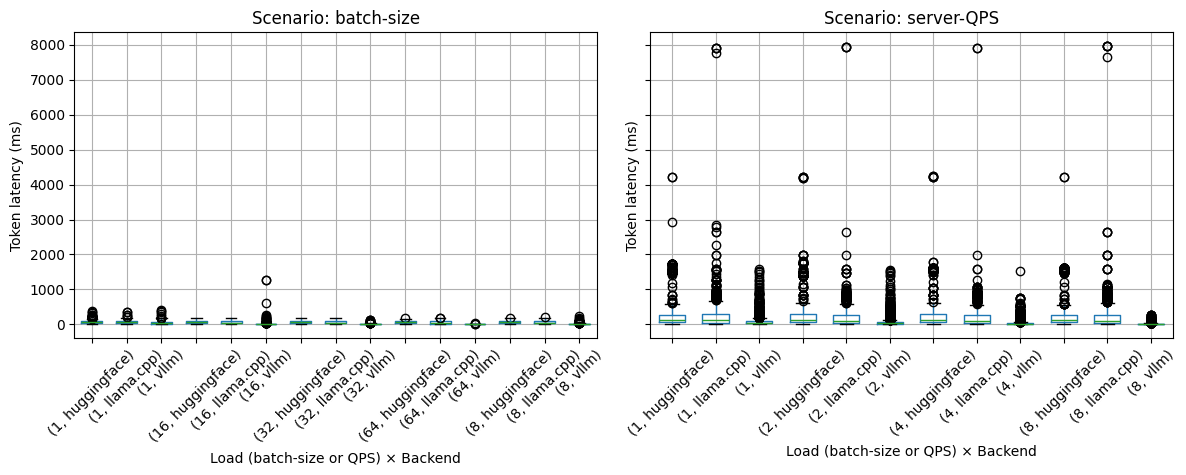

In [44]:
#!/usr/bin/env python3
"""Unified analysis for *single, batch, server* CSVs in `experiment_3/`, reporting
**token-level latency**, **energy per token**, and **GPU utilization**.

Filenames accepted:
    backend_model_task_16batch.csv
    backend_model_task_4QPS_120s_server.csv
"""
# %% ── imports ────────────────────────────────────────────────────────────────
import os, re, glob, pandas as pd

TOK = re.compile(r"\S+")
SENT= re.compile(r"[.!?…]+")

# ── lightweight counters ------------------------------------------------------

def _tok_cnt(t):   return len(TOK.findall(str(t)))

def _sent_cnt(t):  return max(len(SENT.findall(str(t))), 1)

# ── filename parser -----------------------------------------------------------
FILE_RE = re.compile(r"""
    (?P<backend>[^_]+)_
    (?P<model>[^_]+)_
    (?P<task>[^_]+)_
    (?:
        (?P<batch>\d+)batch |
        (?P<qps>\d+)QPS_(?P<secs>\d+)s_server
    )\.csv$""", re.X)

def parse_name(path):
    m = FILE_RE.search(os.path.basename(path))
    if not m:
        return None
    d = m.groupdict()
    if d["batch"]:
        return d["backend"], d["model"], d["task"], "batch-size", int(d["batch"])
    return d["backend"], d["model"], d["task"], "server-QPS", int(d["qps"])

# ── metric fixes --------------------------------------------------------------

def _row_fix(df):
    df = df.copy()
    df["tok"]  = df["generated_answer"].map(_tok_cnt)
    df["sent"] = df["generated_answer"].map(_sent_cnt)
    df["GL"]   = df["GL"] / df["batch_size"]
    df["ATL"]  = df["GL"] / df["tok"]              # Average Token Latency
    df["TPS"]  = df["tok"] / df["GL"]
    return df

def fix_batch(df):
    df = _row_fix(df)
    df["token_latency"] = df["ATL"]
    # energy: duplicated per batch → divide by total tokens in that batch
    if "Total Energy (Wh)" in df:
        df["Energy per Token (J/token)"] = df["Total Energy (Wh)"] * 3600 / df["tok"]
    return df.drop(columns=["tok","sent"], errors="ignore")

def fix_server(df):
    df = df.copy()
    df["tok"]  = df["generated_answer"].map(_tok_cnt)
    df["sent"] = df["generated_answer"].map(_sent_cnt)
    df["launch"] = df.groupby("start_ts")["tok"].transform("size")
    df["GL"]   = df["GL"] / df["launch"]
    df["ATL"]  = df["GL"] / df["tok"]
    df["TPS"]  = df["tok"] / df["GL"]
    df["token_latency"] = df["ATL"]
    if "Total Energy (Wh)" in df:
        batch_energy_wh = df.groupby("start_ts")["Total Energy (Wh)"].transform("max")
        total_tok       = df.groupby("start_ts")["tok"].transform("sum")
        df["Energy per Token (J/token)"] = batch_energy_wh * 3600 / total_tok
    return df.drop(columns=["tok","sent","launch"], errors="ignore")

# %% ── load all CSVs ─────────────────────────────────────────────────────────-
rows = []
results_dir = "/home/ubuntu/fast_llm_inference/results/experiment_3"
for csv in glob.glob(os.path.join(results_dir, "*.csv")):
    parsed = parse_name(csv)
    if not parsed:
        continue
    backend, model, task, scenario, load = parsed
    df = pd.read_csv(csv)
    if "batch_size" not in df.columns:
        df["batch_size"] = load          # only for batch runs
    df["backend"], df["model"], df["task"] = backend, model, task
    df["scenario"], df["load"] = scenario, load
    df = fix_server(df) if scenario.startswith("server") else fix_batch(df)
    rows.append(df)

data = pd.concat(rows, ignore_index=True)

# convert to milliseconds per token
data["token_latency"] *= 1000

import matplotlib.pyplot as plt

# --- assume your `data` DataFrame is already defined, with columns:
#     ['backend','scenario','load','token_latency', …]
# and token_latency in milliseconds.

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, scenario in zip(axes, ["batch-size", "server-QPS"]):
    df = data[data["scenario"] == scenario].copy()
    df["load_str"] = df["load"].astype(str)  # easier labeling
    
    # Draw a boxplot of token_latency grouped by (load, backend)
    df.boxplot(
        column="token_latency",
        by=["load_str", "backend"],
        ax=ax,
        rot=45,
        widths=0.6
    )
    
    ax.set_title(f"Scenario: {scenario}")
    ax.set_xlabel("Load (batch-size or QPS) × Backend")
    ax.set_ylabel("Token latency (ms)")

# Remove the automatic “Boxplot grouped by …” super‐title
plt.suptitle("")  
plt.tight_layout()
plt.show()